In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
# Load the data
data = pd.read_excel('Online Retail.xlsx')

In [3]:
# Filter out rows with missing CustomerID
data = data[data['CustomerID'].notnull()]

In [4]:
# Convert InvoiceDate to datetime format
data['InvoiceDay'] = data['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

In [5]:
# Calculate the RFM values
pin_date = max(data['InvoiceDay']) + dt.timedelta(1)
data['TotalSum'] = data['Quantity'] * data['UnitPrice']
rfm = data.groupby('CustomerID').agg({
    'InvoiceDay': lambda x: (pin_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})
rfm.rename(columns={
    'InvoiceDay': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

In [6]:
# Segment the customers into clusters using K-means
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values
X = rfm[['R', 'F', 'M']]

In [7]:
# Find the optimal number of clusters using the elbow method
wcss = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, algorithm='elkan')
    kmeans.fit(X)
    wcss[k] = kmeans.inertia_

<AxesSubplot:>

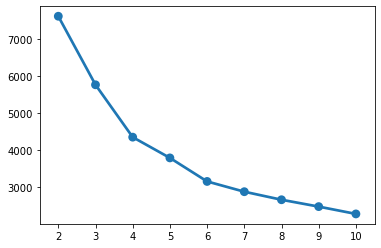

In [8]:
# Plot the elbow curve
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))

In [9]:
# Apply K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=400, random_state=0, algorithm='elkan')
kmeans.fit(X)
rfm['kmeans_cluster'] = kmeans.labels_

In [10]:
# Analyze the clusters
cluster_means = rfm.groupby('kmeans_cluster').mean()
overall_mean = rfm.mean()

C:\Users\Hacker\AppData\Local\Temp\ipykernel_5536\2552005491.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  overall_mean = rfm.mean()


In [11]:
# Print the results
print(cluster_means)
print(overall_mean)

                   Recency   Frequency     Monetary
kmeans_cluster                                     
0                62.052743   94.921941  1570.481363
1               166.672050   37.122981   671.248883
2                12.427729  254.446411  5717.089243
3                22.476945   25.230548   410.106398
4               202.125551   11.758811   189.427898
Recency             92.581199
Frequency           93.053294
Monetary          1898.459701
kmeans_cluster       1.956313
dtype: float64
